# 03 — EDA: Structured Features

**Goal:** Build Rung 2 (theory) and Rung 3 (cross-asset) features, inspect distributions and correlations, verify no data leakage, and save to parquet.

**Sections:**
1. Setup
2. Theory features (Rung 2)
3. Cross-asset features (Rung 3)
4. Feature missingness
5. Correlation matrix
6. Feature vs return scatter
7. Save

## 1. Setup

In [1]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_CLEAN = PROJECT_ROOT / "data-clean"

import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.config import load_config
from src.clean import read_parquet, write_parquet
from src.features_structured import build_structured_features

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
warnings.filterwarnings("ignore")

cfg = load_config(PROJECT_ROOT / "configs" / "config.yaml")

In [2]:
fomc    = read_parquet(DATA_CLEAN / "fomc_metadata.parquet")
bars    = read_parquet(DATA_CLEAN / "intraday_bars.parquet")
targets = read_parquet(DATA_CLEAN / "targets.parquet")
policy  = read_parquet(DATA_CLEAN / "policy_rates.parquet").set_index("date")
policy.index = pd.to_datetime(policy.index)

print(f"Loaded: {len(fomc)} meetings, {len(bars):,} bars, {len(targets)} target rows")

INFO: Read 41 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/fomc_metadata.parquet
INFO: Read 77025 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/intraday_bars.parquet
INFO: Read 328 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/targets.parquet
INFO: Read 1341 rows ← /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/policy_rates.parquet


Loaded: 41 meetings, 77,025 bars, 328 target rows


## 2. Theory Features (Rung 2)

In [3]:
feat_struct = build_structured_features(
    fomc_meta=fomc,
    policy_rates=policy,
    bars=bars,
    pair_cb_map=cfg.pair_cb_map,
    pre_start=cfg.pre_window.start,
    pre_end=cfg.pre_window.end,
)

print(f"Feature matrix: {feat_struct.shape}")
feat_struct.head(8)

INFO: Theory features: 164 rows (meeting × pair)
INFO: Cross-asset features: 41 rows (one per meeting)
INFO: Structured features: 164 rows, 15 columns


Feature matrix: (164, 15)


,meeting_id,pair,rate_change_bps,fed_minus_foreign_pre,spread_change,is_hike,is_cut,is_hold,dissent_count,ust2y_pre_chg,ust10y_pre_chg,slope_pre_change,spx_pre_ret_bps,vix_pre_level,vix_pre_change
0,20210127,USDEUR,NaN,0.08,NaN,0,0,0,0,0.0039,0.0034,-0.0005,-14.234127,27.82,1.21
1,20210127,USDJPY,NaN,0.18,NaN,0,0,0,0,0.0039,0.0034,-0.0005,-14.234127,27.82,1.21
2,20210127,USDGBP,NaN,-0.02,NaN,0,0,0,0,0.0039,0.0034,-0.0005,-14.234127,27.82,1.21
3,20210127,USDCAD,NaN,-0.17,NaN,0,0,0,0,0.0039,0.0034,-0.0005,-14.234127,27.82,1.21
4,20210317,USDEUR,0.0,0.07,-0.01,0,0,1,0,-0.0060,-0.0070,-0.0010,-13.035563,20.77,0.00
5,20210317,USDJPY,0.0,0.17,-0.01,0,0,1,0,-0.0060,-0.0070,-0.0010,-13.035563,20.77,0.00
6,20210317,USDGBP,0.0,-0.03,-0.01,0,0,1,0,-0.0060,-0.0070,-0.0010,-13.035563,20.77,0.00
7,20210317,USDCAD,0.0,-0.18,-0.01,0,0,1,0,-0.0060,-0.0070,-0.0010,-13.035563,20.77,0.00


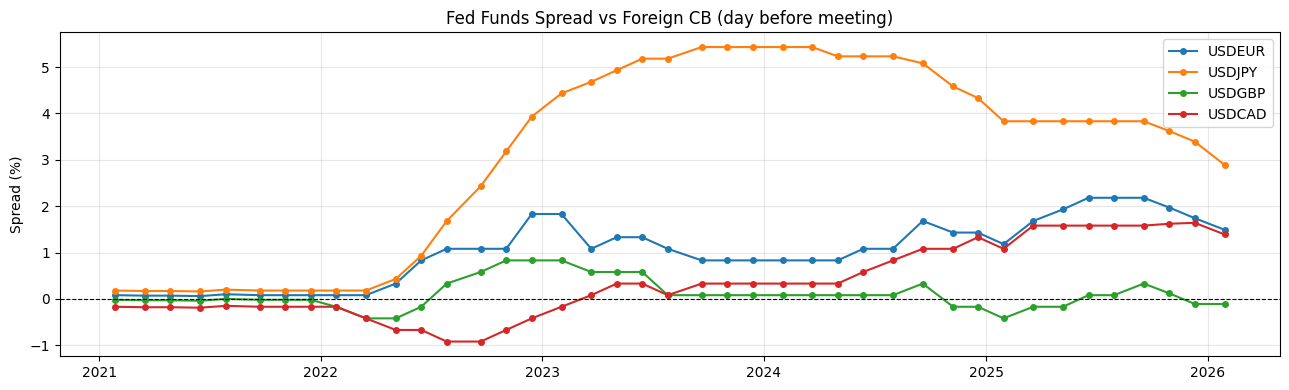

In [4]:
# Policy spread over time per pair
fig, ax = plt.subplots(figsize=(13, 4))

for pair in cfg.pairs:
    sub = feat_struct[feat_struct["pair"] == pair].copy()
    sub = sub.merge(fomc[["meeting_id", "announcement_et"]], on="meeting_id")
    ax.plot(sub["announcement_et"], sub["fed_minus_foreign_pre"], marker="o", ms=4, label=pair)

ax.axhline(0, color="k", lw=0.8, ls="--")
ax.set_title("Fed Funds Spread vs Foreign CB (day before meeting)")
ax.set_ylabel("Spread (%)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Cross-Asset Features (Rung 3)

In [5]:
cross_cols = ["ust2y_pre_chg", "ust10y_pre_chg", "slope_pre_change", "spx_pre_ret_bps", "vix_pre_level", "vix_pre_change"]

# These are meeting-level — take first pair's rows
cross_asset = feat_struct[feat_struct["pair"] == cfg.pairs[0]][cross_cols + ["meeting_id"]].copy()
cross_asset = cross_asset.merge(fomc[["meeting_id", "announcement_et"]], on="meeting_id")

print("Cross-asset feature summary:")
print(cross_asset[cross_cols].describe().round(4))

Cross-asset feature summary:
       ust2y_pre_chg  ust10y_pre_chg  slope_pre_change  spx_pre_ret_bps  \
count        40.0000         41.0000           40.0000          41.0000   
mean          0.0029         -0.0007           -0.0017          -3.3566   
std           0.0135          0.0207            0.0122          19.2538   
min          -0.0273         -0.0777           -0.0325         -47.3494   
25%          -0.0046         -0.0118           -0.0055         -13.0356   
50%           0.0040         -0.0019           -0.0018          -2.2994   
75%           0.0102          0.0097            0.0047           5.1309   
max           0.0270          0.0447            0.0253          45.3223   

       vix_pre_level  vix_pre_change  
count        41.0000         41.0000  
mean         19.4334          0.0488  
std           4.9748          0.3579  
min          12.3500         -0.5700  
25%          16.0100         -0.1300  
50%          17.7800          0.0400  
75%          22.4300  

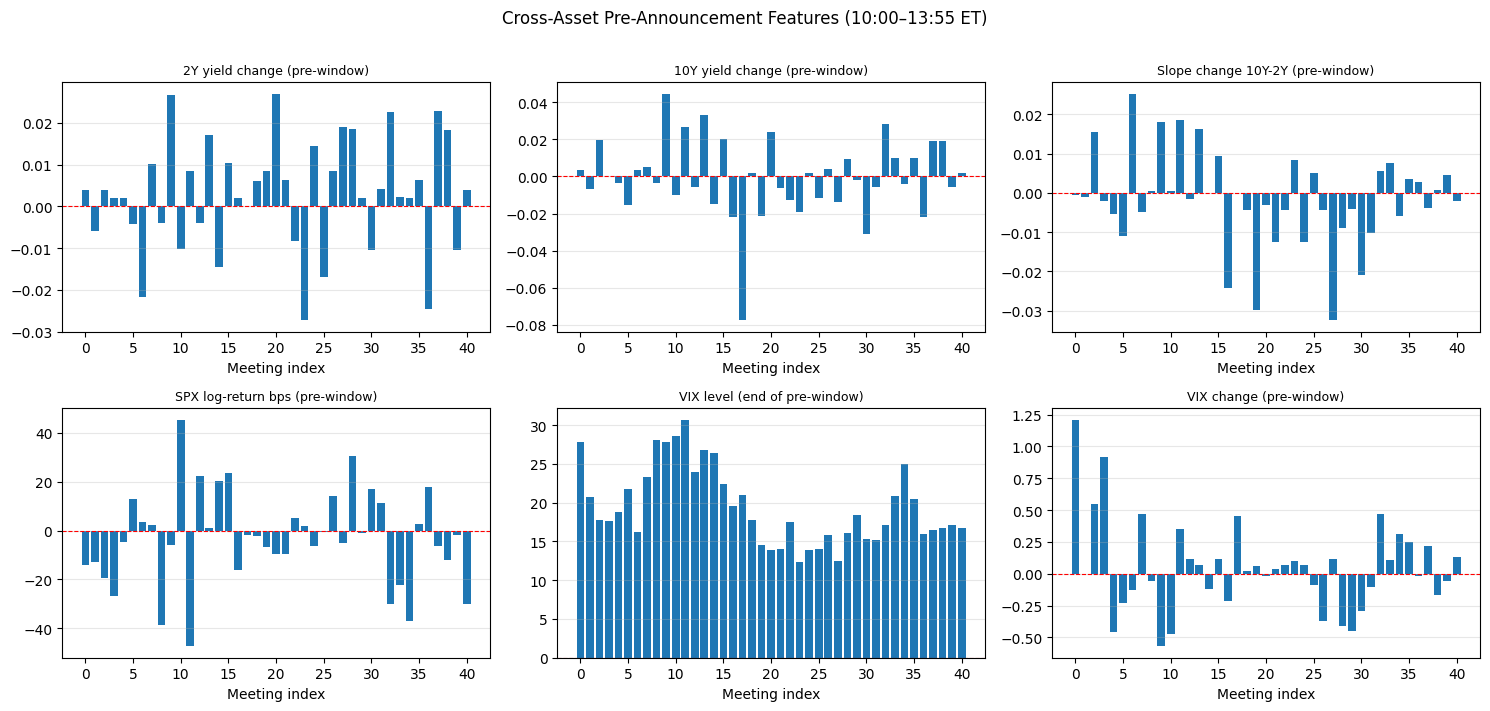

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()

labels = {
    "ust2y_pre_chg": "2Y yield change (pre-window)",
    "ust10y_pre_chg": "10Y yield change (pre-window)",
    "slope_pre_change": "Slope change 10Y-2Y (pre-window)",
    "spx_pre_ret_bps": "SPX log-return bps (pre-window)",
    "vix_pre_level": "VIX level (end of pre-window)",
    "vix_pre_change": "VIX change (pre-window)",
}

for ax, col in zip(axes, cross_cols):
    ax.bar(range(len(cross_asset)), cross_asset[col], width=0.8)
    ax.axhline(0, color="red", lw=0.8, ls="--")
    ax.set_title(labels[col], fontsize=9)
    ax.set_xlabel("Meeting index")
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle(f"Cross-Asset Pre-Announcement Features ({cfg.pre_window.start}–{cfg.pre_window.end} ET)", y=1.01)
plt.tight_layout()
plt.show()

## 4. Feature Missingness

In [7]:
feature_cols = [
    "rate_change_bps", "fed_minus_foreign_pre", "spread_change",
    "is_hike", "is_cut", "is_hold", "dissent_count",
    "ust2y_pre_chg", "ust10y_pre_chg", "slope_pre_change",
    "spx_pre_ret_bps", "vix_pre_level", "vix_pre_change",
]

miss = feat_struct[feature_cols].isna().mean().sort_values(ascending=False) * 100
print("Missing % per feature:")
print(miss.round(1))

if (miss > 10).any():
    print("\n⚠ Features with >10% missing:")
    print(miss[miss > 10])
else:
    print("\n✓ All features have <10% missingness")

Missing % per feature:
rate_change_bps          2.4
spread_change            2.4
ust2y_pre_chg            2.4
slope_pre_change         2.4
fed_minus_foreign_pre    0.0
is_hike                  0.0
is_cut                   0.0
is_hold                  0.0
dissent_count            0.0
ust10y_pre_chg           0.0
spx_pre_ret_bps          0.0
vix_pre_level            0.0
vix_pre_change           0.0
dtype: float64

✓ All features have <10% missingness


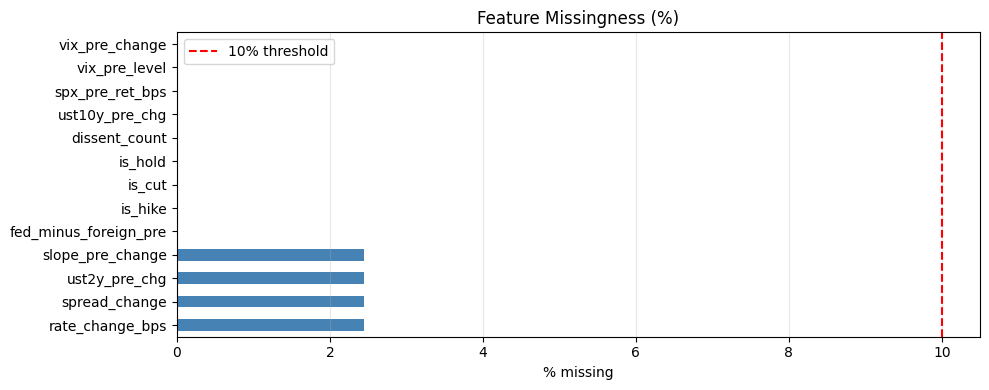

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
miss.plot(kind="barh", ax=ax, color="steelblue")
ax.axvline(10, color="red", lw=1.5, ls="--", label="10% threshold")
ax.set_title("Feature Missingness (%)")
ax.set_xlabel("% missing")
ax.legend()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 5. Correlation Matrix

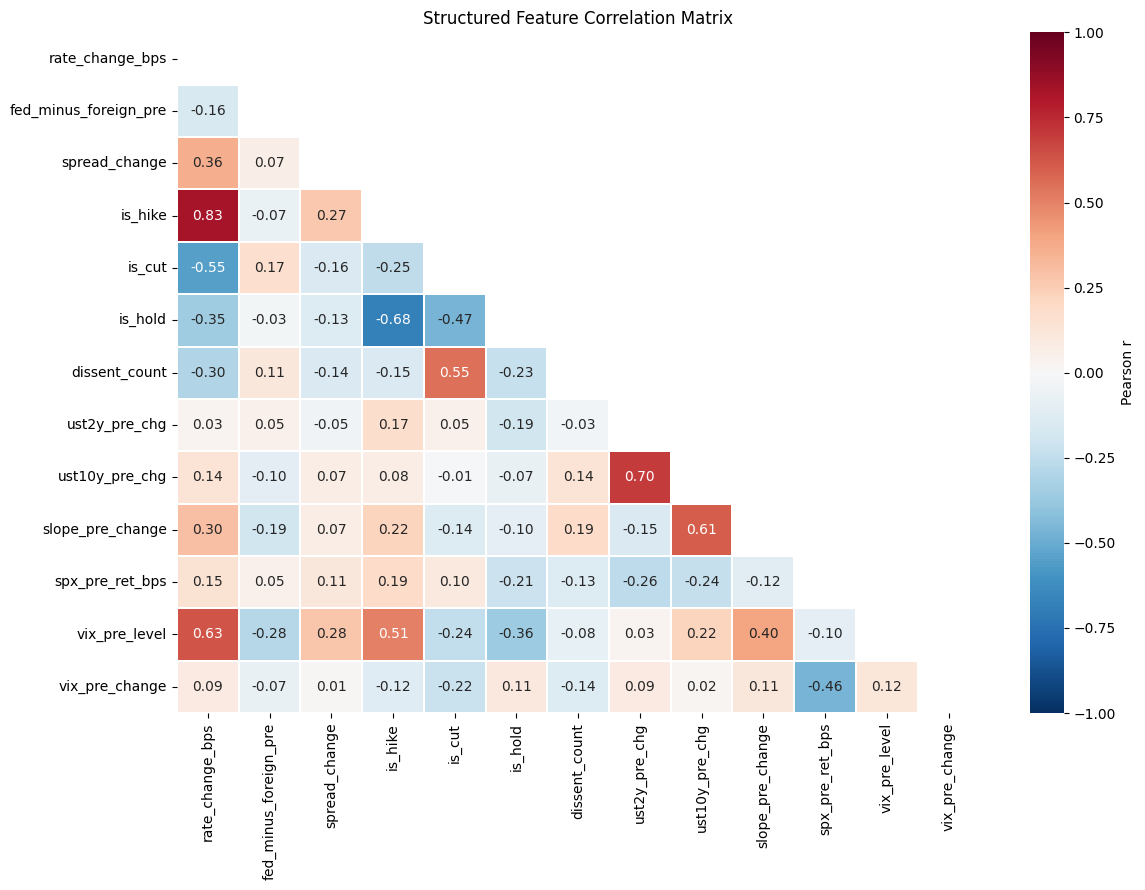

In [9]:
corr = feat_struct[feature_cols].corr()

fig, ax = plt.subplots(figsize=(12, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, ax=ax,
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    annot=True, fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Pearson r"},
)
ax.set_title("Structured Feature Correlation Matrix")
plt.tight_layout()
plt.show()

## 6. Feature vs Return Scatter (Sanity Check)

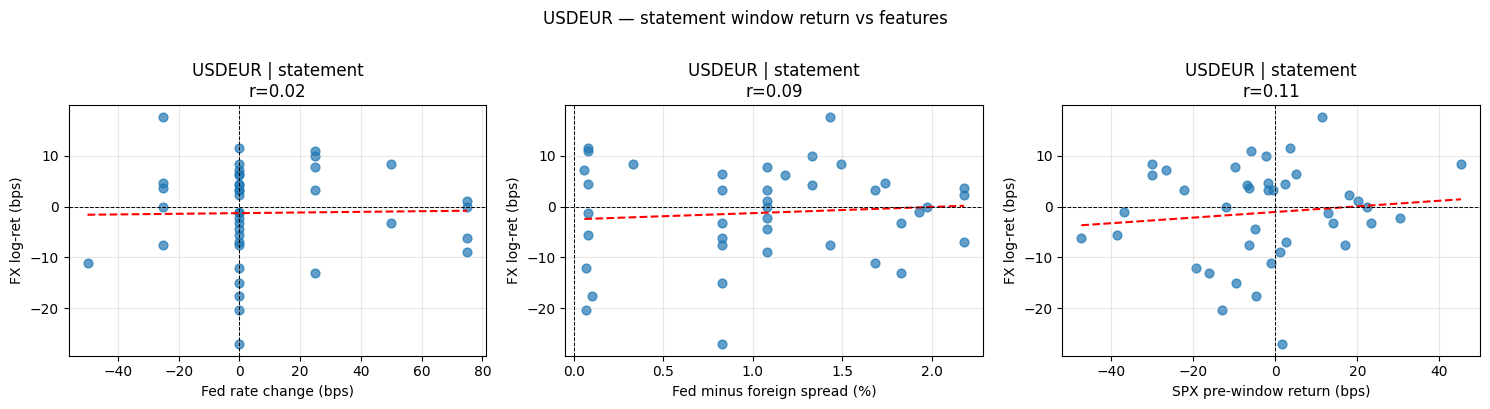

In [10]:
# Merge features with targets for one pair × window
panel = targets[targets["has_data"] & (targets["window"] == "statement")].copy()
panel["log_ret_bps"] = panel["log_ret"] * 10_000

merged = panel.merge(feat_struct, on=["meeting_id", "pair"], how="left")

# Plot rate_change_bps vs return (theory: hike → USD appreciation → positive return)
pair_to_plot = "USDEUR"
sub = merged[merged["pair"] == pair_to_plot].dropna(subset=["rate_change_bps", "log_ret_bps"])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

scatter_pairs = [
    ("rate_change_bps", "Fed rate change (bps)"),
    ("fed_minus_foreign_pre", "Fed minus foreign spread (%)"),
    ("spx_pre_ret_bps", "SPX pre-window return (bps)"),
]

for ax, (feat, xlabel) in zip(axes, scatter_pairs):
    sub_f = sub.dropna(subset=[feat])
    ax.scatter(sub_f[feat], sub_f["log_ret_bps"], alpha=0.7, s=40)
    # Trend line
    if len(sub_f) > 2:
        z = np.polyfit(sub_f[feat], sub_f["log_ret_bps"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(sub_f[feat].min(), sub_f[feat].max(), 50)
        ax.plot(x_line, p(x_line), "r--", lw=1.5)
        corr_val = sub_f[[feat, "log_ret_bps"]].corr().iloc[0, 1]
        ax.set_title(f"{pair_to_plot} | statement\nr={corr_val:.2f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("FX log-ret (bps)")
    ax.axhline(0, color="k", lw=0.7, ls="--")
    ax.axvline(0, color="k", lw=0.7, ls="--")
    ax.grid(True, alpha=0.3)

plt.suptitle(f"{pair_to_plot} — statement window return vs features", y=1.01)
plt.tight_layout()
plt.show()

In [11]:
# Pairwise correlation of each feature with return, by pair × window
corr_rows = []
for pair in cfg.pairs:
    for window_name in ["statement", "digestion"]:
        sub = merged[(merged["pair"] == pair) & (merged["window"] == window_name)].dropna(subset=["log_ret_bps"])
        for feat in feature_cols:
            sub_f = sub.dropna(subset=[feat])
            if len(sub_f) > 5:
                r = sub_f[[feat, "log_ret_bps"]].corr().iloc[0, 1]
            else:
                r = np.nan
            corr_rows.append({"pair": pair, "window": window_name, "feature": feat, "r": r})

corr_df = pd.DataFrame(corr_rows)
corr_pivot = corr_df.pivot_table(index="feature", columns=["pair", "window"], values="r")
print("Feature-return correlations:")
print(corr_pivot.round(2).to_string())

Feature-return correlations:
pair                     USDCAD    USDEUR    USDGBP    USDJPY
window                statement statement statement statement
feature                                                      
dissent_count              0.20      0.25      0.18      0.07
fed_minus_foreign_pre      0.12      0.06     -0.14     -0.09
is_cut                     0.10      0.10      0.10     -0.02
is_hike                    0.07      0.13      0.18      0.22
is_hold                   -0.20     -0.22     -0.25     -0.20
rate_change_bps           -0.01      0.02      0.09      0.10
slope_pre_change           0.17      0.09      0.04      0.12
spread_change             -0.18     -0.12     -0.15      0.02
spx_pre_ret_bps           -0.08      0.10      0.00      0.05
ust10y_pre_chg             0.10      0.11      0.12      0.09
ust2y_pre_chg              0.12      0.16      0.22      0.17
vix_pre_change             0.20      0.12      0.11      0.11
vix_pre_level             -0.04      0.08

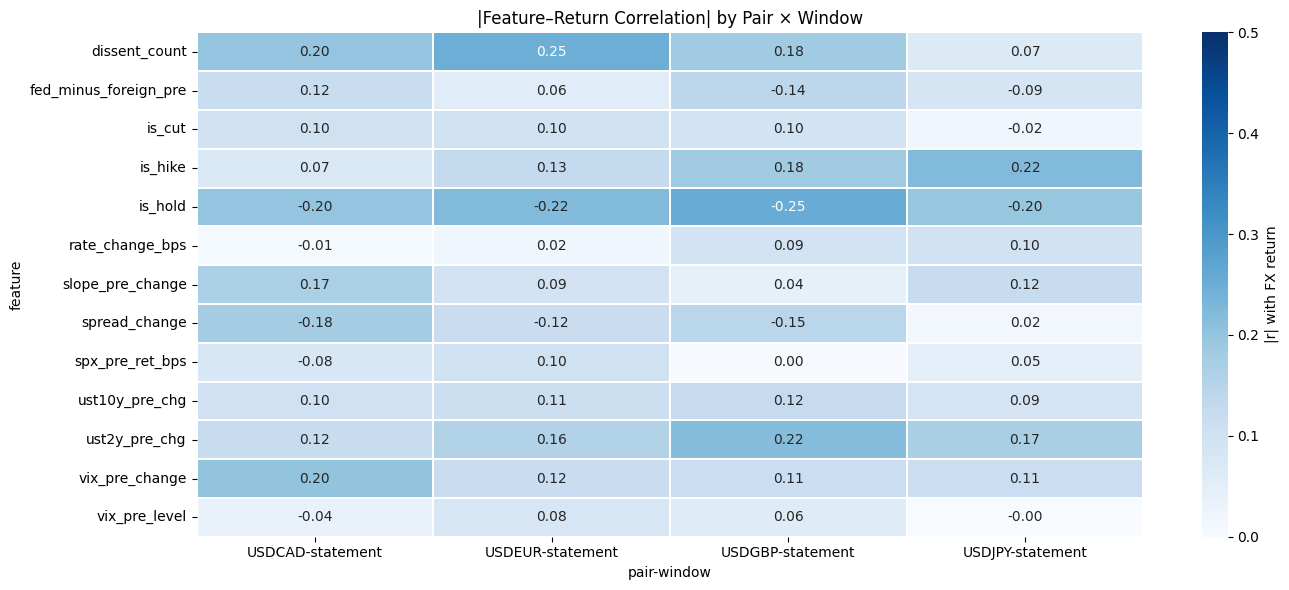

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
corr_pivot_plot = corr_pivot.abs()  # absolute correlation for heatmap
sns.heatmap(
    corr_pivot_plot, ax=ax,
    cmap="Blues", vmin=0, vmax=0.5,
    annot=corr_pivot.round(2), fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "|r| with FX return"},
)
ax.set_title("|Feature–Return Correlation| by Pair × Window")
plt.tight_layout()
plt.show()

## 7. Save

In [13]:
write_parquet(feat_struct, DATA_CLEAN / "features_structured.parquet")
print(f"Saved {len(feat_struct)} rows, {feat_struct.shape[1]} columns")
print(feat_struct.dtypes)

INFO: Wrote 164 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/features_structured.parquet


Saved 164 rows, 15 columns
meeting_id                object
pair                      object
rate_change_bps          float64
fed_minus_foreign_pre    float64
spread_change            float64
is_hike                    int64
is_cut                     int64
is_hold                    int64
dissent_count              int64
ust2y_pre_chg            float64
ust10y_pre_chg           float64
slope_pre_change         float64
spx_pre_ret_bps          float64
vix_pre_level            float64
vix_pre_change           float64
dtype: object


## Summary

| Feature group | Count | Missing% |
|---|---|---|
| Theory (Rung 2) | 3 | see above |
| Meeting metadata | 4 | 0% |
| Cross-asset (Rung 3) | 6 | see above |

**Next:** `04_text_scoring.ipynb` — keyword-based and LLM rubric scoring of FOMC transcripts.